### Overview

In this section, we will take a single Landsat 8 scene downloaded from the [USGS EarthExplorer](https://earthexplorer.usgs.gov/) and learn how to read it using XArray, visualize it and mask clouds.

### Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install rioxarray
  !pip install jupyter-server-proxy

In [ ]:
import os
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import zipfile
import numpy as np

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
landsat_scene = 'LC08_L2SP_144052_20190209_20200829_02_T1.zip'
data_url = 'https://storage.googleapis.com/spatialthoughts-public-data/'

download(data_url + 'landsat/' + landsat_scene)


### Data Pre-Processing

We first unzip the zip archive and create a XArray Dataset from the individual band images.



In [ ]:
landsat_filepath = os.path.join(data_folder, landsat_scene)

with zipfile.ZipFile(landsat_filepath) as zf:
  zf.extractall(data_folder)

Sentinel-2 images come as individual GeoTIFF rasters for each band. The image band files cotaining data from the OLI sensor are named such as `*_SR_B1.TIF`, `*_SR_B2.TIF` etc. We find the files and read them using `rioxarray`.

In [ ]:
import glob

band_files = {}

for filepath in glob.glob(
    os.path.join(data_folder, '*SR_B*.TIF')):
  filename = os.path.basename(filepath)
  # Extract the part of the filename containing band name such as 'B01'
  band_name = os.path.splitext(filename)[0].split('_')[-1]
  band_files[band_name] = filepath

band_files

We read the bands using `rioxarray` and combine them into a single DataArray.

In [ ]:
bands = []

for band_name, band_path in band_files.items():
  ds = rxr.open_rasterio(band_path, chunks=True, masked=True)
  ds.name = band_name
  bands.append(ds)

scene = xr.concat(bands, dim='band').assign_coords(
    band=list(band_files.keys()))
scene

Landsat Collection 2 surface reflectance has a scale factor of `0.0000275` and an additional offset of `-0.2` per pixel. We apply the scale and offset to get the reflectance values



In [ ]:
scaled = (scene*0.0000275) - 0.2

### Visualization

We can visualize a 3-band composite image.

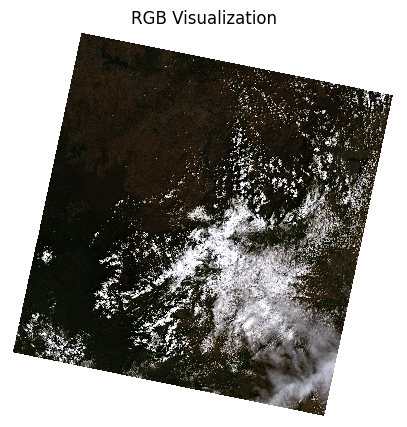

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
scaled.sel(band=['B4', 'B3', 'B2']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

### Applying a Cloud Mask

Most satellite providers store pixel quality information as bitmasks. This allows the providers to store a lot more information in an efficient way. Bitmasks can be hard to understand. Please read our post on [Working with QA Bands and Bitmasks in Google Earth Engine
](https://spatialthoughts.com/2021/08/19/qa-bands-bitmasks-gee/) to understand the concepts. Here we apply the same concept using a Python implementation of bitmasking adapted from Google Earth Engine.

Read the QA band which comes with a filename ending with `*QA_PIXEL.TIF`.

In [ ]:
for qa_filepath in glob.glob(
    os.path.join(data_folder, '*QA_PIXEL.TIF')):
  break

pixel_qa = rxr.open_rasterio(qa_filepath, chunks=True, masked=True)
pixel_qa.name = 'pixel_qa'
pixel_qa

In [ ]:
pixel_qa = pixel_qa.squeeze().astype('int64')
pixel_qa

The 16-bit pixel value is determined by setting each of the bits to 0 or 1.

Since we are interested in clouds, the first 5 bits are relevant

| Bit | Description  |
| --- | ------------ |
| 0   | Fill         |
| 1   | Dilated Cloud|
| 2   | Cirrus       |
| 3   | Cloud        |
| 4   | Cloud Shadow |

We create a mask using the `np.bitwise_and()` function against the binary number `11111`. The result will be 0 only if all the bits are set to 0 indicating clear conditions.

In [ ]:
mask = xr.full_like(pixel_qa, int('11111', 2))
qa_mask = np.bitwise_and(pixel_qa, mask) == (0)
qa_mask

In [ ]:
scene_masked = scaled.where(qa_mask)
scene_masked

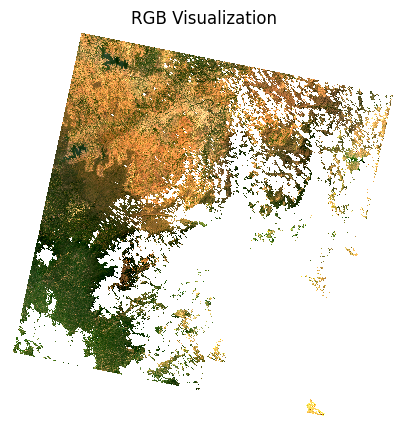

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
scene_masked.sel(band=['B4', 'B3', 'B2']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

Let's write the resulting masked as a multi-band GeoTIFF file using rioxarray. We convert the DataArray to a DataSet with each band being a separate variable. This results in a much nicer GeoTIFF that is compatible with desktop software.



In [ ]:
output_file = 'landsat_masked.tif'
output_path = os.path.join(output_folder, output_file)

output_ds = scene_masked.to_dataset('band')
output_ds[['B4', 'B3', 'B2']].rio.to_raster(output_path, compress='deflate')